# Basic linear regression

## Data processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unittest
import itertools

from functions import fillna_by_time, Check_fillna_by_time
unittest.main(argv=["", "Check_fillna_by_time"], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.020s

OK


In [2]:
building_info = pd.read_csv('.\data\\building_metadata.csv')
train_meters = pd.read_csv('.\data\\train.csv')
weather_train = pd.read_csv('.\data\\weather_train.csv')

In [3]:
building_info.head(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [4]:
# separate tasks
electricity = train_meters[train_meters.meter==0].drop('meter', axis=1)
chilledwater = train_meters[train_meters.meter==1].drop('meter', axis=1)
steam = train_meters[train_meters.meter==2].drop('meter', axis=1)
hotwater = train_meters[train_meters.meter==3].drop('meter', axis=1)

del train_meters

In [5]:
# let's start with electricity
# we should join dataframes to see the whole picture
electricity = electricity.set_index('building_id').join(
    building_info.set_index('building_id'), 
    on='building_id')
electricity.set_index(pd.Index([i for i in range(len(electricity))]), inplace=True)

In [6]:
# remove nans
electricity['floor_count'].fillna(electricity['floor_count'].median(), inplace=True)
electricity['year_built'].fillna(electricity['year_built'].median(), inplace=True)

In [7]:
for i in electricity.columns:
    part = 'has Nans!!!' if electricity[i].isna().any() else 'doesn\'t have Nans'
    print(f'column {i} {part}')

column timestamp doesn't have Nans
column meter_reading doesn't have Nans
column site_id doesn't have Nans
column primary_use doesn't have Nans
column square_feet doesn't have Nans
column year_built doesn't have Nans
column floor_count doesn't have Nans


In [8]:
print('There are', len(weather_train['site_id'].unique()), 'unique site_ids')

mean_for_site_id = 0
for i in weather_train['site_id'].unique():
    mean_for_site_id += weather_train['site_id'][weather_train['site_id'] == i].count()
mean_for_site_id /= len(weather_train['site_id'].unique())

print('But for every site_id there are in average', int(mean_for_site_id), 'rows')
print('We are going to have', int(mean_for_site_id)*len(electricity),'raws at all!!!')

There are 16 unique site_ids
But for every site_id there are in average 8735 rows
We are going to have 105352048850 raws at all!!!


In [9]:
for index in weather_train['site_id'].unique():
    testing_site_id = weather_train[weather_train['site_id'] == index]
    
    with_nans = testing_site_id['air_temperature'].isna()
    for i in testing_site_id.columns:
        with_nans |= testing_site_id[i].isna()

    print('for', index, len(testing_site_id[~with_nans])/len(testing_site_id), 
          'of data doesn\'t have Nans at all')

for 0 0.5429189435336976 of data doesn't have Nans at all
for 1 0.0 of data doesn't have Nans at all
for 2 0.6747125128088353 of data doesn't have Nans at all
for 3 0.5714123006833713 of data doesn't have Nans at all
for 4 0.4361835363770921 of data doesn't have Nans at all
for 5 0.0 of data doesn't have Nans at all
for 6 0.5867683898884081 of data doesn't have Nans at all
for 7 0.0 of data doesn't have Nans at all
for 8 0.5429189435336976 of data doesn't have Nans at all
for 9 0.44123006833712985 of data doesn't have Nans at all
for 10 0.666021407424277 of data doesn't have Nans at all
for 11 0.0 of data doesn't have Nans at all
for 12 0.0 of data doesn't have Nans at all
for 13 0.49379483092337473 of data doesn't have Nans at all
for 14 0.5924575595305913 of data doesn't have Nans at all
for 15 0.006505796072864916 of data doesn't have Nans at all


In [10]:
# research features for each site_id == 0
# drop time and site_id because they are not useful now
# (time just shows us the order to sort)
testing_site_id = weather_train[weather_train['site_id'] == 0].drop('site_id', axis=1)
for i in testing_site_id.columns[1:]:
    testing_site_id = fillna_by_time(testing_site_id, i)
testing_site_id = testing_site_id.drop('timestamp', axis=1)

testing_site_id.head(3)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5
2,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


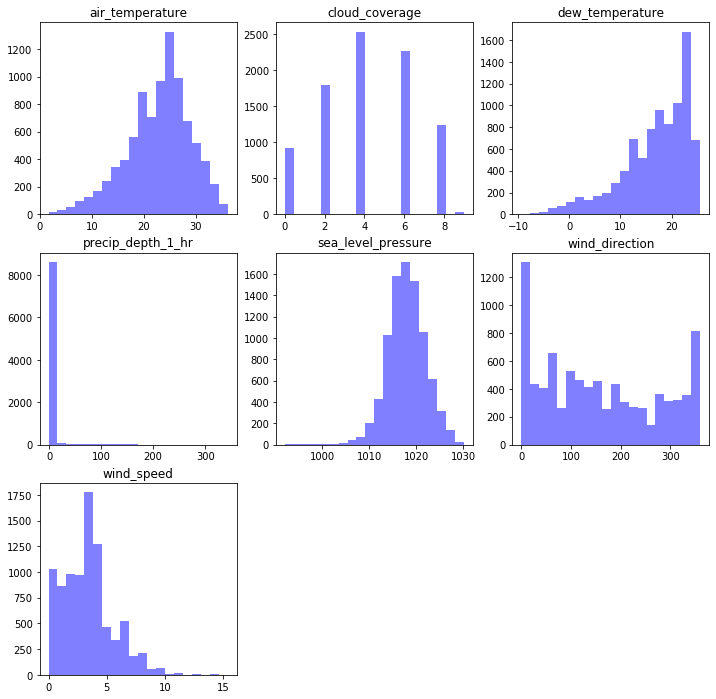

In [11]:
num_bins = 20
plt.figure(figsize=(12, 12))

index = 1
for i in testing_site_id.columns:
    plt.subplot((len(testing_site_id.columns)+2)//3, 3, index)
    plt.title(i)
    n, bins, patches = plt.hist(testing_site_id[i], num_bins, facecolor='blue', alpha=0.5)
    index += 1

plt.show()

In [12]:
# precip_depth_1_hr now doesn't have any useful info
testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)

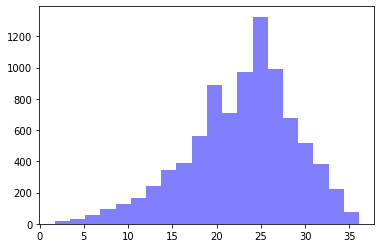

In [71]:
# let's fit normal distribution on our data
def get_in_columns(column, testing_site_id):
    y, x, patches = plt.hist(testing_site_id[column], num_bins, facecolor='blue', alpha=0.5)
    x = np.array(x[:-1], dtype='float32')
    y = np.array(y, dtype='float32')

    x = ((x - x.mean())/x.max())*10
    y /= y.max()
    
    return x, y

x, y = get_in_columns('air_temperature', testing_site_id)

In [16]:
import tensorflow as tf
from IPython.display import clear_output

In [17]:
from tensorflow.keras import layers

class DestributionLayer(layers.Layer):
    def __init__(self, mu=0., st=1.):
        super(DestributionLayer, self).__init__()
        
        self.mu_var = mu
        self.st_var = st
        
        self.trainable = True
        
    def build(self, input_shape):
        self.mu = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.mu_var),
                             trainable=True)
        
        self.st = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.st_var),
                             trainable=True)
        
    def call(self, inputs):
        return tf.math.exp(-(inputs - self.mu)**2 / (2*self.st)) / tf.math.sqrt(2*np.pi*self.st)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

Train on 20 samples
Epoch 1/1000
20/20 [==============================] - 1s 42ms/sample - loss: 0.6174
Epoch 2/1000
20/20 [==============================] - 0s 49us/sample - loss: 0.5926
Epoch 3/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5765
Epoch 4/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.5638
Epoch 5/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.5532
Epoch 6/1000
20/20 [==============================] - 0s 99us/sample - loss: 0.5439
Epoch 7/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5356
Epoch 8/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5279
Epoch 9/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5208
Epoch 10/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5142
Epoch 11/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.5079
Epoch 12/1000
20/20 [==========================

Epoch 97/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.2451
Epoch 98/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.2432
Epoch 99/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.2412
Epoch 100/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.2393
Epoch 101/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.2375
Epoch 102/1000
20/20 [==============================] - 0s 48us/sample - loss: 0.2356
Epoch 103/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.2338
Epoch 104/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.2320
Epoch 105/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.2303
Epoch 106/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.2286
Epoch 107/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.2269
Epoch 108/1000
20/20 [============================

Epoch 192/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.1324
Epoch 193/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.1315
Epoch 194/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.1307
Epoch 195/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.1298
Epoch 196/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.1289
Epoch 197/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.1281
Epoch 198/1000
20/20 [==============================] - 0s 99us/sample - loss: 0.1272
Epoch 199/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.1264
Epoch 200/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.1256
Epoch 201/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.1247
Epoch 202/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.1239
Epoch 203/1000
20/20 [==========================

Epoch 287/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0702
Epoch 288/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0697
Epoch 289/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.0693
Epoch 290/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0688
Epoch 291/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0684
Epoch 292/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0679
Epoch 293/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.0674
Epoch 294/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0670
Epoch 295/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0665
Epoch 296/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0661
Epoch 297/1000
20/20 [==============================] - 0s 148us/sample - loss: 0.0657
Epoch 298/1000
20/20 [======================

Epoch 382/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0363
Epoch 383/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0361
Epoch 384/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0358
Epoch 385/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0356
Epoch 386/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.0353
Epoch 387/1000
20/20 [==============================] - 0s 99us/sample - loss: 0.0351
Epoch 388/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0349
Epoch 389/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0347
Epoch 390/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0344
Epoch 391/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0342
Epoch 392/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0340
Epoch 393/1000
20/20 [======================

Epoch 477/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0202
Epoch 478/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0200
Epoch 479/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0198
Epoch 480/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0197
Epoch 481/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0195
Epoch 482/1000
20/20 [==============================] - 0s 50us/sample - loss: 0.0193
Epoch 483/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0192
Epoch 484/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0190
Epoch 485/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0188
Epoch 486/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0186
Epoch 487/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0184
Epoch 488/1000
20/20 [=======================

Epoch 572/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0068
Epoch 573/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0067
Epoch 574/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0067
Epoch 575/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0066
Epoch 576/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.0065
Epoch 577/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0065
Epoch 578/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.0064
Epoch 579/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0063
Epoch 580/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.0063
Epoch 581/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0062
Epoch 582/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.0062
Epoch 583/1000
20/20 [=======================

Epoch 667/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0031
Epoch 668/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0031
Epoch 669/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0030
Epoch 670/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0030
Epoch 671/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0030
Epoch 672/1000
20/20 [==============================] - 0s 150us/sample - loss: 0.0030
Epoch 673/1000
20/20 [==============================] - 0s 99us/sample - loss: 0.0030
Epoch 674/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0030
Epoch 675/1000
20/20 [==============================] - 0s 49us/sample - loss: 0.0030
Epoch 676/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0029
Epoch 677/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0029
Epoch 678/1000
20/20 [========================

Epoch 762/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 763/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0024
Epoch 764/1000
20/20 [==============================] - 0s 50us/sample - loss: 0.0024
Epoch 765/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 766/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0024
Epoch 767/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0024
Epoch 768/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 769/1000
20/20 [==============================] - 0s 50us/sample - loss: 0.0024
Epoch 770/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 771/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 772/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 773/1000
20/20 [========================

Epoch 857/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 858/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 859/1000
20/20 [==============================] - 0s 151us/sample - loss: 0.0024
Epoch 860/1000
20/20 [==============================] - 0s 98us/sample - loss: 0.0024
Epoch 861/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 862/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 863/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 864/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 865/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 866/1000
20/20 [==============================] - 0s 101us/sample - loss: 0.0024
Epoch 867/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 868/1000
20/20 [======================

Epoch 952/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 953/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 954/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 955/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 956/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 957/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 958/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 959/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 960/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 961/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 962/1000
20/20 [==============================] - 0s 100us/sample - loss: 0.0024
Epoch 963/1000
20/20 [=====================

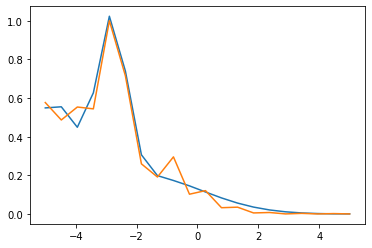

In [95]:
def loss(y, y_pred):
    return tf.reduce_mean((y_pred-y)**2)
def maxis(y):
    return tf.reduce_max(y)
    
def distribution_model(num_layers):
    inputs_ = layers.Input((1,))
    sp = []
    for i in range(5):
        sp.append(DestributionLayer((np.random.rand(1)*2-1)*2, 0.5)(inputs_))
    predictions = sum(sp)

    model_ = tf.keras.Model(
            inputs=inputs_, 
            outputs=predictions)

    model_.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
                  loss=loss)
    
    return model_

num_layers = 5
model = distribution_model(num_layers)
model.fit(x, y, batch_size=len(x), epochs=1000)
plt.plot(x, model(x))
plt.plot(x, y)
plt.show()

In [60]:
# we have a distribution layer
# so, we can simulate any distribution using stacking of this layer

In [97]:
site_info

,mu0,st0,mu1,st1,mu2,st2,mu3,st3,mu4,st4
air_temperature,-3.251350,2.358476,-0.034421,1.057647,1.236214,2.149010,1.859640,0.438934,3.434780,1.751771
cloud_coverage,-3.859175,2.190976,-3.766344,2.170359,-0.786436,0.103360,0.450523,2.242136,1.883494,0.118061
dew_temperature,-3.591432,2.338505,-0.816938,2.239919,1.621186,2.259812,3.570646,2.320390,3.735657,2.326649
sea_level_pressure,0.930949,0.243927,0.951367,0.248261,1.056296,0.019123,1.713845,0.066775,2.201904,0.116636
wind_direction,-3.774231,2.140254,-3.771609,2.141006,-0.518812,2.208433,0.238147,2.234690,3.272343,1.976669
wind_speed,-3.685147,1.146279,-2.645423,2.161175,-2.442783,2.237254,0.240919,2.370936,3.562009,2.421936


In [134]:
site_info = pd.DataFrame(index = ['site_id'], columns = [i + '_' + j for i in testing_site_id.columns 
                                    for j in list(itertools.chain(*[['mu' + str(i), 'st' + str(i)]
                                                                for i in range(num_layers)]))])

Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 0.1227
Train on 20 samples
20/20 [==============================] - 1s 26ms/sample - loss: 0.4713
Train on 20 samples
20/20 [==============================] - 1s 43ms/sample - loss: 0.3523
Train on 20 samples
20/20 [==============================] - 0s 25ms/sample - loss: 5.0465
Train on 20 samples
20/20 [==============================] - 1s 26ms/sample - loss: 0.4857
Train on 20 samples
20/20 [==============================] - 1s 25ms/sample - loss: 0.4917


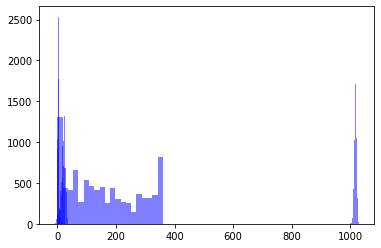

In [135]:
data_per_site_id = []
for i in testing_site_id.columns:
    temp = []
    model = distribution_model(num_layers)
    x, y = get_in_columns(i, testing_site_id)
    model.fit(x, y, batch_size=len(x), epochs=1000)
    
    for j in model.weights:
        temp.append(j.numpy()[0])
        
    temp = [[temp[i*2], temp[i*2+1]] for i in range(num_layers)]
    temp.sort()
    data_per_site_id.append(list(itertools.chain(*temp)))

site_info.loc[0] = [data_per_site_id[i][j] for i in range(len(testing_site_id.columns)) for j in range(num_layers*2)]

In [137]:
site_info.set_index('site_id')

,air_temperature_mu0,air_temperature_st0,air_temperature_mu1,air_temperature_st1,air_temperature_mu2,air_temperature_st2,air_temperature_mu3,air_temperature_st3,air_temperature_mu4,air_temperature_st4,...,wind_speed_mu0,wind_speed_st0,wind_speed_mu1,wind_speed_st1,wind_speed_mu2,wind_speed_st2,wind_speed_mu3,wind_speed_st3,wind_speed_mu4,wind_speed_st4
site_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-1.917432,0.531622,0.013424,0.531612,0.762784,0.531623,1.470166,0.531623,1.928186,0.531621,...,-1.181457,0.531623,-1.131846,0.531623,-0.473219,0.531623,1.455073,0.531623,1.746952,0.531623


In [138]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [ ]:
# our regression should understand where to put zeros